## Week 1
Folium is used for plotting nice maps

In [43]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
#!wget "https://s3.amazonaws.com/divvy-data/tripdata/Divvy_Trips_2016_Q3Q4.zip"

In [3]:
# !mkdir data
# !mv Divvy_Trips_2016_Q3Q4.zip data/Divvy_Trips_2016_Q3Q4.zip

In [4]:
# !unzip data/Divvy_Trips_2016_Q3Q4.zip -d data/Divvy_Trips_2016_Q3Q4

In [3]:
divvyStations_q3 = pd.read_csv('data/Divvy_Trips_2016_Q3Q4/Divvy_Stations_2016_Q3.csv')
divvyStations_q4 = pd.read_csv('data/Divvy_Trips_2016_Q3Q4/Divvy_Stations_2016_Q4.csv')

# combine and keep the first instance of id
divvyStations = pd.concat([divvyStations_q3, divvyStations_q4], axis=0).drop_duplicates(subset=['id'])

divvyStations.head()

,id,name,latitude,longitude,dpcapacity,online_date
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013
3,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,6/21/2013
4,80,Aberdeen St & Monroe St,41.880420,-87.655599,19,6/26/2013


In [37]:
m = folium.Map([41.8781, -87.6298], zoom_start=13)
m

In [38]:
# mark each station as a point
for index, row in divvyStations.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=2,
                        popup=row['name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)

In [48]:
# convert to (n, 2) nd-array format for heatmap
stationArr = divvyStations[['latitude', 'longitude']].values

# plot heatmap
#m.add_child(plugins.HeatMap(stationArr, radius=2, gradient={0.4: "blue", 0.65: "lime", 1: "red"}))
m.add_child(plugins.HeatMap(stationArr, radius=2, blur=15, min_opacity=0.2))
#m.add_child(plugins.heat_map(stationArr, radius=2))
#m
#hm = plugins.HeatMap(stationArr, radius=2)
#m.add_child(hm)
m

# Load Divvy Activity Files and Analyze Same Station Rides
The Divvy activity files are split by quarters. We want to concatenate the result of multiple calls to pd.read_csv() so let's be Pythonic and use generators. I adapted a solution I found on Stack Overflow. (Praise Be)

In [9]:
divvyTripFiles = ['data/Divvy_Trips_2016_Q3Q4/Divvy_Trips_2016_Q3.csv',
                  'data/Divvy_Trips_2016_Q3Q4/Divvy_Trips_2016_Q4.csv']

divvyTrips = (pd.read_csv(f) for f in divvyTripFiles)
divvyTripsCombined = pd.concat(divvyTrips, ignore_index=True)

divvyTripsCombined.describe(include='all')

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
count,2.125643e+06,2125643,2125643,2.125643e+06,2.125643e+06,2.125643e+06,2125643,2.125643e+06,2125643,2125643,1590189,1.590343e+06
unique,NaN,1846706,1779098,NaN,NaN,NaN,584,NaN,584,3,2,NaN
top,NaN,9/14/2016 17:27:19,7/23/2016 12:54:37,NaN,NaN,NaN,Streeter Dr & Grand Ave,NaN,Streeter Dr & Grand Ave,Subscriber,Male,NaN
freq,NaN,7,17,NaN,NaN,NaN,59247,NaN,64948,1589954,1180122,NaN
mean,1.169926e+07,NaN,NaN,3.251980e+03,1.008547e+03,1.799161e+02,NaN,1.803518e+02,NaN,NaN,NaN,1.980787e+03
std,7.313875e+05,NaN,NaN,1.730437e+03,1.816103e+03,1.305240e+02,NaN,1.304878e+02,NaN,NaN,NaN,1.075399e+01
min,1.042666e+07,NaN,NaN,1.000000e+00,6.000000e+01,2.000000e+00,NaN,2.000000e+00,NaN,NaN,NaN,1.899000e+03
25%,1.106635e+07,NaN,NaN,1.755000e+03,4.160000e+02,7.500000e+01,NaN,7.500000e+01,NaN,NaN,NaN,1.975000e+03
50%,1.170150e+07,NaN,NaN,3.446000e+03,7.160000e+02,1.570000e+02,NaN,1.570000e+02,NaN,NaN,NaN,1.984000e+03
75%,1.233129e+07,NaN,NaN,4.802000e+03,1.195000e+03,2.680000e+02,NaN,2.720000e+02,NaN,NaN,NaN,1.989000e+03


In [10]:
# Three usertypes? This wasn't mentioned in the readme. Let's investigate
divvyTripsCombined.groupby('usertype')['trip_id'].agg(len)

usertype
Customer       535649
Dependent          40
Subscriber    1589954
Name: trip_id, dtype: int64

In [11]:
## There is a 'Dependent' usertype with 40 entries, let's drop this
divvyTripsCombined = divvyTripsCombined[divvyTripsCombined.usertype != 'Dependent']

# How many trips went from Station A all the way to Station A
totalTrips = len(divvyTripsCombined)
sameStationTrips = divvyTripsCombined[divvyTripsCombined.from_station_id == divvyTripsCombined.to_station_id]
sameStationTrips.is_copy = False
# sameStationTrips.__getattribute__(self, name)
totalTrips = len(divvyTripsCombined)
sameStationTrips = divvyTripsCombined[divvyTripsCombined.from_station_id == divvyTripsCombined.to_station_id]
sameStationTrips.is_copy = False

print ('Total number of trips: {:,}'.format(totalTrips))
print (('Trips from A -> A: {:,}').format(len(sameStationTrips)))
print (('Trips from A -> A: {:.1%}').format(len(sameStationTrips) / totalTrips))

Total number of trips: 2,125,603
Trips from A -> A: 73,730
Trips from A -> A: 3.5%


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [12]:
# % of same station trips by usertype
num_trips_by_usertype = divvyTripsCombined.groupby('usertype')['trip_id'].agg(len)
num_same_station_trips_by_usertype = sameStationTrips.groupby('usertype')['trip_id'].agg(len)
num_same_station_trips_by_usertype / num_trips_by_usertype

usertype
Customer      0.090636
Subscriber    0.015838
Name: trip_id, dtype: float64

#### This seems like a pretty high percentage of rides to me. Let's look into this a bit more:

* How long are these trips? Accidental checkouts?
* Who is taking them?
* Where are they taking them to?
* Tourists who don't know where the next station is? Or subscribers running errards around the neighbourhood?
* Can we draw conclusions?

In [13]:
sameStationTrips['tripInMinutes'] = sameStationTrips['tripduration'] / 60
sameStationTrips.describe()


,trip_id,bikeid,tripduration,from_station_id,to_station_id,birthyear,tripInMinutes
count,7.373000e+04,73730.000000,73730.000000,73730.000000,73730.000000,25204.000000,73730.000000
mean,1.151064e+07,3219.399769,2360.523261,192.533473,192.533473,1980.622798,39.342054
std,6.886428e+05,1731.021515,4078.805054,153.248962,153.248962,11.690790,67.980084
min,1.042666e+07,1.000000,60.000000,2.000000,2.000000,1900.000000,1.000000
25%,1.091862e+07,1716.000000,504.000000,69.000000,69.000000,1974.000000,8.400000
50%,1.144692e+07,3395.000000,1383.000000,164.000000,164.000000,1985.000000,23.050000
75%,1.205419e+07,4764.000000,2888.000000,291.000000,291.000000,1989.000000,48.133333
max,1.297922e+07,5919.000000,86365.000000,620.000000,620.000000,2000.000000,1439.416667


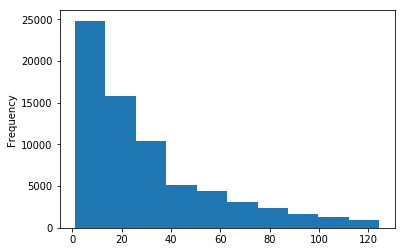

In [14]:
# check out trip in minutes distrubtion
tripDuration = sameStationTrips['tripInMinutes']
tripDuration[tripDuration < tripDuration.quantile(.95)].plot(kind='hist')

usertype
Customer      AxesSubplot(0.125,0.125;0.775x0.755)
Subscriber    AxesSubplot(0.125,0.125;0.775x0.755)
Name: tripInMinutes, dtype: object

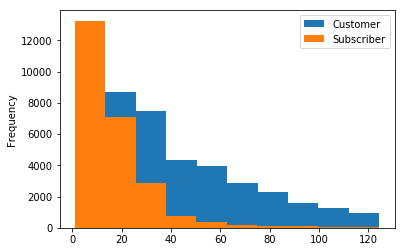

In [15]:
# distribution grouped by subscriber type
sameStationTrips[tripDuration < tripDuration.quantile(.95)] \
  .groupby('usertype')['tripInMinutes'].plot(kind='hist', stacked=True, legend=True)

usertype
Customer      AxesSubplot(0.125,0.125;0.775x0.755)
Subscriber    AxesSubplot(0.125,0.125;0.775x0.755)
Name: tripInMinutes, dtype: object

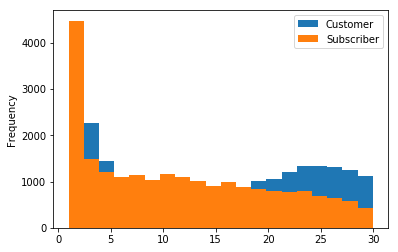

In [16]:
# Divvy's charge more for rides larger than 30 minutes so lets see that
# distribution of usage for less than 30
sameStationTrips[sameStationTrips['tripInMinutes'] < 30] \
    .groupby('usertype')['tripInMinutes'] \
    .plot(kind='hist', stacked=True, legend=True, bins=20)

There seems to be a lot of same station trips < 3 minutes. A three minute station to station trip probably implies a mistaken bicycle checkout. Let's go ahead and exclude rides that are less than 3 minutes and see how the distribution looks.

In [17]:
old_count = len(sameStationTrips)
sameStationTrips = sameStationTrips[sameStationTrips.tripInMinutes > 3]
new_count = len(sameStationTrips)
print ('Num records dropped: {}'.format(old_count-new_count))

Num records dropped: 9398


usertype
Customer      AxesSubplot(0.125,0.125;0.775x0.755)
Subscriber    AxesSubplot(0.125,0.125;0.775x0.755)
Name: tripInMinutes, dtype: object

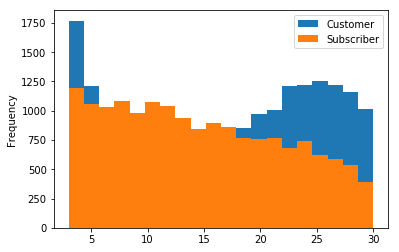

In [18]:
# examine the <30 minute ride distribution again
sameStationTrips[sameStationTrips['tripInMinutes'] < 30] \
    .groupby('usertype')['tripInMinutes'] \
    .plot(kind='hist', stacked=True, legend=True, bins=20)

In [19]:
# Acording to Folium docs, we can pass the heatmap function a (n, 3) ndarray
# with weights in the column
sameStationCountsByStationID = sameStationTrips.groupby('from_station_id')['trip_id'].agg('count')
sameStationCountsByStationID.name = 'numTrips'

In [20]:
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByStationID.to_frame(), how='outer',
                               left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['numTrips'].fillna(value=0)
sameStationCountsDF.head(2)

,id,name,latitude,longitude,dpcapacity,online_date,numTrips
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015,6.0
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015,137.0


#### We will create a helper function with default keyword arguments to abstact away Folium's complexity. This leaves us with a simple API we can use going forward.

In [21]:
def map_points(df, lat_col='latitude', lon_col='longitude', zoom_start=11, 
                plot_points=False, pt_radius=15, 
                draw_heatmap=False, heat_map_weights_col=None, 
                heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['name'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].values
        curr_map.add_child(plugins.HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [22]:
map_points(sameStationCountsDF, plot_points=True, draw_heatmap=True, heat_map_weights_normalize=True,
          heat_map_weights_col='numTrips')

### Subscriber vs Customer Heatmaps

In [23]:
sameStationCountsByUserTypeStationID = sameStationTrips[['from_station_id', 'usertype', 'trip_id']] .groupby(['usertype', 'from_station_id']).agg('count')

selected = 'Customer'
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByUserTypeStationID.loc[selected],
                               how='outer', left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['trip_id'].fillna(value=0)

map_points(sameStationCountsDF, plot_points=False, draw_heatmap=True,
           heat_map_weights_normalize=False, heat_map_weights_col='numTrips', heat_map_radius=9)

In [24]:
selected = 'Subscriber'
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByUserTypeStationID.loc[selected],
                               how='outer', left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['trip_id'].fillna(value=0)

map_points(sameStationCountsDF, plot_points=False, draw_heatmap=True,
           heat_map_weights_normalize=False, heat_map_weights_col='numTrips', heat_map_radius=9)

## Conclusion
From the maps above, we can see that day pass customers tend to use stations around Lake Michigan and The Loop (Chicago's downtown). This matches up with what I was expecting: that tourists get on a bike to experience Chicago in a different way before continuing with other parts of their trip.

The annual members, on the other hand, have a usage map that is a bit more spread out to the neighborhoods. This could suggest they are running errand before returning their bike to the station where they retrieved it from. I've used Divvy in this manner to pick up take out from a restaurant outside walking distance.

# part 6 load data

In [25]:
# load the police incident data
data = pd.read_csv("data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
# Preview the first 5 lines of the loaded data 
data.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160
